In [1]:
# standard imports\n",
import os
import random
import numpy as np

# work with data\n",
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import glob
from tqdm.auto import tqdm
from IPython.display import clear_output

# like numpy, only good + NN
import torch, torch.nn as nn
import torch.nn.functional as torch_nn_F
from torch.utils.data import DataLoader, Dataset, Subset
# import torchvision
# from torchvision import transforms
import time


# local
import utils

from scipy.linalg import block_diag


plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

# Dark plots\n",
#plt.style.use('dark_background')\n",

TIME_STEP = 1
CLASSNAME = {0: 'ballistic', 1: 'hgv', 2: 'hcm'}
CLASSTYPE = {'ballistic': 0, 'hgv': 1, 'hcm': 2}

# Prepare data
## Load and examine data

In [38]:
# Data reading function
def read_trajectories(path_to_file, look: bool = False):
    with h5py.File(path_to_file, 'r') as dset:
        for k, v in dset.attrs.items():
            print(f"{k}: {v}")

    dset = pd.HDFStore(path_to_file, 'r')
    if look:
        print(dset.info())
    return dset

## Splitting the data

In [4]:
def train_val_test_split(data, tts = (0.7, 0.1, 0.2), shuffle=False):
    '''Split data into train, validation and test sets according to `tts` tuple

    By default, tts = (train, val, test) = (0.7, 0.1, 0.2)
    '''
    assert sum(tts) == 1

    if shuffle:
        data = np.random.shuffle(data)

    h = len(data)
    train = data[:int(h * tts[0])]
    val = data[int(h * tts[0]) : int(h * np.round(tts[0] + tts[1], 4))]
    test = data[int(h * np.round(tts[0] + tts[1], 4)) : int(h * sum(tts))]

    return train, val, test

## Invertible trajectory pre-processing transform

In [74]:
class RelativeTrajectory():
    def __init__(self, df, diff=False, ref_point=30):
    
        self.diff = diff
        self.ref_point = ref_point

        data = np.array(df.drop('t', 1))
        assert data.shape[0] >= ref_point
        
        # Remember first state
        self.start_state = data[0].copy()
        
        # Make changes relative to the start state
        data -= self.start_state

        # Scale data to kilometers
        data /= 1000

        # Rotate coordinate system
        x = utils.normalize(data[-1, :3] - data[0, :3])             # X axis along flight direction
        z = utils.orthogonal(x, data[ref_point, :3] - data[0, :3])  # Z axis along upward (from Earth)
        y = np.cross(z, x)                                          # Y is a cross product to form basis
        
        p = np.array([x, y, z])  # -> Relative CS axes in current frame
        p_prime = np.eye(3)      # -> How they should be
        self.M = utils.get_transformation_matrix(p, p_prime)[:3, :3]
                
        # Perform rotation for coordinates
        data[:, :3] = np.absolute(data[:, :3].dot(self.M))

        # Perform rotation for velocities
        data[:, 3:6] = data[:, 3:6].dot(self.M)

        
        #data = data / data.max(axis=0)
        data[:, 1] = data[:, 1] * 10
        data[:, 0] = data[:, 0] / 2

        
        ## Calculate angle of rotation: arctan(y_r / x_r), where r is ref_point

        self.theta = np.arctan(data[100][1] / data[100][0])

        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, :3] = self.rotate_Z(data[:, :3], -self.theta)


        self.first_diff_elem = None
        if diff:
            self.first_diff_elem = data[0].copy()
            data = np.diff(data, axis=0)

        self.data = data

    def restore(self, columns, ts=1, config=None):

        assert ts > 0

        if config:
            self.set_info(config)

        # Restore diff data
        if self.diff:
            data = np.r_[np.expand_dims(self.first_diff_elem, 0), np.cumsum(self.data, axis=0)]
        else:
            data = self.data.copy()

        # Perform rotation for coordinates
        data[:, 0:3] = data[:, 0:3].dot(np.linalg.inv(self.M))

        # Perform rotation for velocities
        data[:, 3:6] = data[:, 3:6].dot(np.linalg.inv(self.M))

        # Scale data from km back to meters
        data *= 1000
        
        # Make changes absolute
        data += self.start_state

        # Restore Pandas.DataFrame format
        t = np.arange(0, data.shape[0], ts)
        data = np.c_[data, t]
        data = pd.DataFrame(data, columns=columns)

        return data

    @staticmethod
    def rotate_Z(data, theta):
        """Rotate data around the Z axis using matrix R"""
        
        R = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [            0,              0, 1]
        ])
        return data @ R.T

    @staticmethod
    def rotate_X(data, theta):
        """Rotate data around the X axis using matrix R"""
        
        R = np.array([
            [ 1,              0,              0],
            [ 0,  np.cos(theta), -np.sin(theta)],
            [ 0,  np.sin(theta),  np.cos(theta)]
        ])
        return data @ R

    @staticmethod
    def rotate_Y(data, theta):
        """Rotate data around the Y axis using matrix R"""
        
        R = np.array([
            [ np.cos(theta),  0, np.sin(theta)],
            [             0,  1,             0],
            [-np.sin(theta),  0, np.cos(theta)]
        ])
        return data @ R
    
    @property
    def info(self):
        return {
            'ref_point' : self.ref_point,
            'diff' : self.diff,
            'start_state' : self.start_state,
            'first_diff_elem' : self.first_diff_elem,
            'M' : self.M
        }
    
    @info.setter
    def info(self, config):
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_point = config['start_point']
        self.first_diff_elem = config['first_diff_elem']
        self.M = config['M']

## Generation of datasets

In [6]:
def max_min_len_coordinate(dset, keys):
    max_size = 0
    min_size = len(np.array(dset[keys[0]])[:,0])
    for key_k in keys:
        size = len(np.array(dset[key_k])[:,0])
        if size > max_size:
            max_size = size
            max_key = key_k
        if size < min_size:
            min_size = size
            min_key = key_k
    return (max_size, min_size, max_key, min_key)

In [62]:
def get_strided_data_clust(dset, keys, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, verbose=False):
    '''Return list with parts of trajectories and their residuals.
    
    Arguments:
        dset -- h5py Data set with trajectory data
        keys -- keys for extracting data from `dset`
        
    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude
        
        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]
        
        gt_size -- how many trajectory points are to be observed
        horizon -- how many trajectory points are to be predicted
        step -- (default: 1) 
                if 1, every row from the `dset` will be processed,
                if >1, some rows will be skipped accordingly.
        diff -- (default: False) toggle extract differentiated relative trajectories
    '''
    
    assert variables in [3, 6, 7]
    
    # Create list with parts of trajectories,
    # each element has (gt_size+horizon) trajectory points
    data_seqs = []
    
    # Set of configs for each trajectory. 
    configs = {}
    
    # List of trajectory indices 
    # (to which trajectory this traj_elem belongs to)
    traj_ids = []
    
    # Collect trajectories, preprocess and 
    # split them into trajectory parts
    for k in tqdm(range(len(keys)), disable=1-verbose, desc='Collecting strided data'):
        # Get relative trajectory from the dataset
        rt = RelativeTrajectory(dset[keys[k]], diff=diff)
        configs[k] = rt.info  # save for future restoration

        # Collect list of trajectory parts from `rt` 
        # using time window [gt_size + horizon] and time shift `step`
        for i in range(1 + (rt.data.shape[0] - gt_size - horizon) // step):
            data_seqs.append([rt.data[i*step : i*step + gt_size + horizon, :variables]])
            traj_ids.append(k)
    
    data_seqs_noise = np.random.normal(data_seqs, random.randint(1, 2)/100)
    
    # Collect all data seqs into one huge dataset 
    # of shape [? , gt_size + horizon, variables]
    data_seqs_all = np.stack(data_seqs).squeeze()
    data_seqs_all_noise = np.stack(data_seqs_noise).squeeze()
    traj_ids_all = np.stack(traj_ids)

    # Calculate mean and std over all data
    data_mean = data_seqs_all.mean((0, 1))
    data_std = data_seqs_all.std((0, 1))
    res_mean = np.zeros(variables)
    res_std = np.ones(variables)
    
    if residuals:
        # Compute and add columns with residuals
        # note that the first row should be zeros
        # (if we have 8 measurements, we only can have 7 residuals)
        res = np.concatenate((
            np.zeros((data_seqs_all.shape[0], 1, variables)),
            data_seqs_all[:, 1:, :] - data_seqs_all[:, :-1, :]
        ), 1)
    
        res_mean = res[:, 1:].mean((0, 1))
        res_std = res[:, 1:].std((0, 1))
    
        data_seqs_all = np.concatenate((data_seqs_all, res), 2)
    
    stats = {
        'data_mean': data_mean,
        'data_std': data_std,
        'res_mean': res_mean,
        'res_std': res_std
    }
    
    if verbose:
        with np.printoptions(precision=3):
            print(f'Total trajectory parts: {data_seqs_all.shape[0]}')
            print(f'Each: {gt_size} observed + {horizon} horizon = {gt_size+horizon} points in total')
            if residuals:
                print(f'Each point contains {int(data_seqs_all.shape[-1]/2)} variables and {int(data_seqs_all.shape[-1]/2)} residuals')
            else:
                print(f'Each point contains {data_seqs_all.shape[-1]} variables')

            print('Data mean:', stats['data_mean'],
                  'Data std:', stats['data_std'], 
                  sep='\n')
            if residuals:
                print('Residuals mean:', stats['res_mean'],
                      'Residuals std:', stats['res_std'], 
                      sep='\n')
    return (
        data_seqs_all.squeeze()[:, :gt_size], # src sequences
        data_seqs_all.squeeze()[:, gt_size:], # tgt sequences
        data_seqs_all_noise.squeeze()[:, :gt_size], # data_noise sequences
        configs,
        stats,
        traj_ids_all
    )

In [9]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data, name, variables=3, configs=None, stats=None):
        super().__init__()
    
        self.data = data
        self.name = name
        self.variables = variables
        self.configs = configs
        self.stats = stats
        
    def __len__(self):
        return self.data['data'].shape[0]
    
    def __getitem__(self, index):
        
        ret =  {
            'data': torch.Tensor(self.data['data'][index]),
            'tgt': torch.Tensor(self.data['tgt'][index]),
            'data_noise': torch.Tensor(self.data['data_noise'][index]),
            'traj_id': self.data['traj_ids'][index],
        }
        return ret

In [10]:
def create_dataset(dset, keys, name, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, train=True, scaler=None, verbose=False):
    """Create TrajectoryDataset for training NNs.

    Arguments:
        dset -- h5py dataset object
        keys -- list of strings: keys for extracting data from `dset`
        name -- name of the TrajectoryDataset

    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]

        gt_size -- how many points are observed (model input)
        horizon -- how many points the model tries to predict into the future
        step -- stride step for data
        diff -- toggle differentiate trajectories
        train -- this data will be used for training
        scaler -- custom scaler, so data will have zero mean and unit variance
        verbose -- toggle print info to the terminal
        
    Note:
        If `train == True`, the scaler will fit on the collected data and
        then returned as the TrajectoryDataset.scaler attribute
        
        If 'train == False', this function will look for scaler from the 
        arguments, then use it to scale collected data for evaluation.
    """
    if verbose:
        print(f"Loading dataset in {'train' if train else 'evaluation'} mode...")

    inp, out, inp_noise, configs, stats, traj_ids = get_strided_data_clust(
        dset, keys, variables, residuals, gt_size, horizon, step, diff, verbose)

    data = {
        'data': inp,
        'tgt': out,
        'data_noise': inp_noise,  
        'traj_ids': traj_ids
    }

    return TrajectoryDataset(data, name, variables, configs, stats)

## Recurrent Module

In [11]:
# Our recurrent Module
class ModuleRNN(nn.Module):
    """
    Implement the scheme above as torch module
    torch style
    
    """
    def __init__(self, vect_dim=3, rnn_num_units=64):
        super(self.__class__,self).__init__()
        
        self.num_units = rnn_num_units
        self.vect_dim = vect_dim

#         our linear layer
        self.rnn_update = self.block(vect_dim, rnn_num_units)

        self.rnn_forget = self.block(vect_dim, rnn_num_units)
        self.rnn_save = self.block(vect_dim, rnn_num_units)
        self.rnn_data_selection = self.block(vect_dim, rnn_num_units)
        self.rnn_quick_overview = self.block(vect_dim, rnn_num_units)

        self.rnn_prediction = self.predicted_block(rnn_num_units+vect_dim, vect_dim)

        
    def forward(self, new_data, flash_memory, short_term_memory, long_term_memory, F):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        memory = torch.cat([new_data, short_term_memory], dim=-1)

        forgetfulness = torch.sigmoid(self.rnn_forget(memory)) #forgetting dataforgetting data
        conservation = torch.tanh(self.rnn_save(memory)) #the acquisition of new data
        information = torch.sigmoid(self.rnn_data_selection(memory))

        long_term_memory = (forgetfulness * long_term_memory) + (information * conservation)

        short_term_memory = torch.sigmoid(self.rnn_quick_overview(memory)) * torch.tanh(long_term_memory)
        
        with torch.no_grad():
            flash_memory = self.predict_Kalman(F, flash_memory)
            flash_memory_grad = flash_memory[:,0::3]


        predicted_data = self.rnn_prediction(torch.cat([flash_memory_grad, short_term_memory], dim=-1))

        with torch.no_grad(): 
            flash_memory[:,0::3] = predicted_data

        return predicted_data, flash_memory, short_term_memory, long_term_memory

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, dtype=torch.float32, requires_grad=True)

    def initial_state_old_data(self, batch_size):
        return torch.zeros(batch_size, self.vect_dim*3, dtype=torch.float32, requires_grad=True)

    def block(self, in_f, out_f):
        return nn.Sequential(
            self.base_block(in_f + out_f, (in_f + 2 * out_f)//2),
            self.base_block((in_f + 2 * out_f)//2, out_f)
        )


    def base_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, out_f),
        )

    def predicted_block(self, in_f, out_f):
        return nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_f, (in_f + out_f)//2),
            nn.Dropout(0.5),
            nn.Linear((in_f + out_f)//2, out_f),
            
        )

    def predict_Kalman(self, F, old_data):
        return torch.mm(F, old_data.transpose(0,1)).transpose(0,1)


In [12]:
'''
RNN old
without kalman
'''
# Our recurrent Module
class ModuleRNN(nn.Module):
    """
    Implement the scheme above as torch module
    torch style
    
    """
    def __init__(self, vect_dim=3, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

#         our linear layer
        self.rnn_update = self.block(vect_dim, rnn_num_units)

        self.rnn_forget = self.block(vect_dim, rnn_num_units)
        self.rnn_save = self.block(vect_dim, rnn_num_units)
        self.rnn_data_selection = self.block(vect_dim, rnn_num_units)
        self.rnn_quick_overview = self.block(vect_dim, rnn_num_units)

        
        self.rnn_prediction = self.predicted_block(rnn_num_units, vect_dim)

    def forward(self, new_data, short_term_memory, long_term_memory):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        memory = torch.cat([new_data, short_term_memory], dim=-1)

        forgetfulness = torch.sigmoid(self.rnn_forget(memory)) #forgetting dataforgetting data
        conservation = torch.tanh(self.rnn_save(memory)) #the acquisition of new data
        information = torch.sigmoid(self.rnn_data_selection(memory))

        long_term_memory = (forgetfulness * long_term_memory) + (information * conservation)

        short_term_memory = torch.sigmoid(self.rnn_quick_overview(memory)) * torch.tanh(long_term_memory)



        #compute logits for next character probs
        predicted_data = self.rnn_prediction(short_term_memory)

        return predicted_data, short_term_memory, long_term_memory

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

    def block(self, in_f, out_f):
        return nn.Sequential(
            self.base_block(in_f + out_f, (in_f + 2 * out_f)//2),
            self.base_block((in_f + 2 * out_f)//2, out_f)
        )


    def base_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, out_f),
        )

    def predicted_block(self, in_f, out_f):
        return nn.Sequential(
            nn.Linear(in_f, (in_f + out_f)//2),
            nn.Dropout(0.05),
            nn.Linear((in_f + out_f)//2, out_f),
            
        )

In [12]:
def preKalman(vect_dim=3, time_step = 0.25):
    F = np.array([[1., time_step, time_step**2/2],
                  [0., 1.,        time_step     ],
                  [0., 0.,        1.            ]])

    
    if vect_dim==3:
          F = block_diag(F, F, F)
    elif vect_dim==2:
          F = block_diag(F, F)

    F = torch.from_numpy(F).type(torch.float32)

    return F


## RNN Loop

In [13]:
def rnn_loop(trajectories_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, vec_dim = batch_ix.size()

    short_term_memory = trajectories_rnn.initial_state(batch_size)
    long_term_memory = trajectories_rnn.initial_state(batch_size)

    flash_memory_copy = torch.zeros(batch_size, vec_dim*3, dtype=torch.float32)
    flash_memory = trajectories_rnn.initial_state_old_data(batch_size)

    flash_memory_copy[:,0::3] = batch_ix.transpose(0,1)[0]
    flash_memory = flash_memory_copy
    predictions = []

    F = preKalman(3, 0.1)

    for new_data in batch_ix.transpose(0,1):
        prediction, flash_memory, short_term_memory, long_term_memory = trajectories_rnn(new_data, flash_memory.to(device), short_term_memory.to(device), long_term_memory.to(device), F.to(device))  # <-- here we call your one-step code
        predictions.append(prediction)

    return torch.stack(predictions, dim=1)

In [13]:
'''
RNN old
without kalman
'''
def rnn_loop(trajectories_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, vec_dim = batch_ix.size()

    short_term_memory = trajectories_rnn.initial_state(batch_size)
    long_term_memory = trajectories_rnn.initial_state(batch_size)
    predictions = []

    for new_data in batch_ix.transpose(0,1):
        prediction, short_term_memory, long_term_memory = trajectories_rnn(new_data, short_term_memory.to(device), long_term_memory.to(device))  # <-- here we call your one-step code
        predictions.append(prediction)

    return torch.stack(predictions, dim=1)

## The training loop

In [14]:
def accuracy(x_pred, x_real, Discrepancy):
    delta = np.absolute(x_pred)-np.absolute(x_real)
    return np.sum(
        (np.absolute(delta/x_pred) <= Discrepancy)|
        (np.absolute(delta/x_real) <= Discrepancy))/ x_real.size

def print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, epoc, EPOC_NUM, lr, now_time, start_time):
    print(f'Epoch {epoc + 1} of {EPOC_NUM} took {now_time - start_time:.3f}s')
    
    print('      training loss:', train_loss[-1],)
    print('    validation loss:', val_loss[-1])
    print('train accuracy:', train_accuracy[-1]*1000//1/10,'%')
    print('validation accuracy:', val_accuracy[-1]*1000//1/10,'%')
    if lr!=0:
        print('changed optimizer lr:', lr)
    # print(f"\t  training loss: {train_loss[-1]:.9f}")
    # print(f"\tvalidation loss: {val_loss[-1]:.9f}")
    # print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    plot_process(train_loss, val_loss, None, train_accuracy, val_accuracy, None)
    if len(train_loss)>5:
        plot_process(train_loss[-5:], val_loss[-5:], None, train_accuracy[-5:], val_accuracy[-5:], None)

In [77]:
def traning_fun(trajectories_rnn, criterion, opt, train_dl, val_dl, train_loss, val_loss, train_accuracy, val_accuracy, Discrepancy, EPOC_NUM, device, draw: bool = False):

    error = 0
    retraining = 0
    

    if (draw)&(len(train_loss)>0):
        for g in opt.param_groups:
                lr =  g['lr']
        print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, 0, EPOC_NUM, lr, time.time(), time.time())
    lr = 0

    for epoc in range(EPOC_NUM):

        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()

        

        if ((epoc+1)%(EPOC_NUM/4) == 0)&(EPOC_NUM > 5): 
            for g in opt.param_groups:
                g['lr'] = g['lr']/10
                lr =  g['lr']
        
        trajectories_rnn.train(True) # enable dropout / batch_norm training behavior
        for id_b, batch_total in enumerate(train_dl):
            opt.zero_grad()
            batch = batch_total['data_noise'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            ) 
            ep_train_accuracy.append(accuracy(predictions.cpu().detach().numpy(), data_real.cpu().detach().numpy().astype(float), Discrepancy))
            
            # train with backprop
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.cpu().data.numpy())

        for id_b, batch_total in enumerate(train_dl):
            opt.zero_grad()
            batch = batch_total['data'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            ) 
            ep_train_accuracy.append(accuracy(predictions.cpu().detach().numpy(), data_real.cpu().detach().numpy().astype(float), Discrepancy))
            
            # train with backprop
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.cpu().data.numpy())
          
        trajectories_rnn.train(False) # enable dropout / batch_norm training behavior
        with torch.no_grad(): 
            for id_b, batch_total in enumerate(val_dl):

                batch = batch_total['data_noise'].to(device, torch.float32)

                predictions = rnn_loop(trajectories_rnn, batch, device)

                # compute loss
                data_real = batch_total['data'].to(device, torch.float32)

                # print(predictions_logp.shape, actual_next_tokens.shape)
                loss = criterion(
                    predictions.contiguous().view(-1),
                    data_real.contiguous().view(-1)
                )
                ep_val_loss.append(loss.cpu().data.numpy())
                ep_val_accuracy.append(accuracy(predictions.cpu().numpy(), data_real.cpu().numpy().astype(float), Discrepancy))
        
        clear_output(True)
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_accuracy.append(np.mean(ep_val_accuracy))

        if error > 0:
            print('Warning: the network is hard to learn.')
        if retraining>EPOC_NUM*3//10:
            print('Warning: the network is being retrained - overfitting.')
        if train_loss[0] < train_loss[-1]:
            error+=1
            assert error!=3, "RNN didn't converge!!!"
        else:
            if error>0:
                error-=1

        if train_loss[-1] < val_loss[-1]:
            retraining+=1
        else:
            if retraining>0:
                retraining-=1

        # print the results for this epoch:
        if draw:
            print_epoc(train_loss, val_loss, train_accuracy, val_accuracy, epoc, EPOC_NUM, lr, time.time(), start_time)
        
    return trajectories_rnn, train_loss, val_loss, train_accuracy, val_accuracy, opt

## Test

In [16]:
def print_test(test_loss, test_accuracy, iteration, iteration_num, now_time, start_time):
    print(f'Iteration {iteration + 1} of {iteration_num} took {now_time - start_time:.3f}s')
    
    print('    testing loss:', test_loss[-1],)
    print('testing accuracy:', test_accuracy[-1]*1000//1/10,'%')
    plot_process(None, None, test_loss, None, None, test_accuracy)

In [17]:
def testing_fun(trajectories_rnn, criterion, test_dl, test_loss, test_accuracy, Discrepancy, device, draw: bool = False):

    start_time = time.time()
    iteration_num = len(test_dl)
    trajectories_rnn.train(False) # enable dropout / batch_norm training behavior
    pack_predictions = []
    with torch.no_grad(): 
        for id_b, batch_total in enumerate(test_dl):
            
            start_time = time.time()

            batch = batch_total['data_noise'].to(device, torch.float32)

            predictions = rnn_loop(trajectories_rnn, batch, device)

            # compute loss
            data_real = batch_total['data'].to(device, torch.float32)

            # print(predictions_logp.shape, actual_next_tokens.shape)
            loss = criterion(
                predictions.contiguous().view(-1),
                data_real.contiguous().view(-1)
            )
            pack_predictions.append(predictions.cpu())
            test_loss.append(loss.cpu().data.numpy())
            test_accuracy.append(accuracy(predictions.cpu().numpy(), data_real.cpu().numpy().astype(float), Discrepancy))
            if draw:
                clear_output(True)
                print_test(test_loss, test_accuracy, id_b, iteration_num, time.time(), start_time)
        
    return pack_predictions, test_loss, test_accuracy

## Drawing

In [18]:
def plot_process(train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy):
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch/Iteration')
  if train_loss != None:
      plt.plot(train_loss, label='train')
  if val_loss != None:
      plt.plot(val_loss, label='validation')
  if test_loss != None:
      plt.plot(test_loss, label='test')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.title('Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch/Iteration')
  if train_accuracy != None:
      plt.plot(train_accuracy, label='train accuracy', color='b')
  if val_accuracy != None:
      plt.plot(val_accuracy, label='validation accuracy', color='r')
  if test_accuracy != None:
      plt.plot(test_accuracy, label='test accuracy', color='r')
  plt.legend()
  plt.grid(True)
  plt.show()

## Save the model

In [19]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

## Pre Training  

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading
name_file_trajectories = '/content/drive/MyDrive/Документы/NN/2021-05-08-04-13.h5' #'/content/2021-05-08-04-13.h5'
try:
    dset = read_trajectories(name_file_trajectories)
except FileNotFoundError:
    assert "NO file!!!"

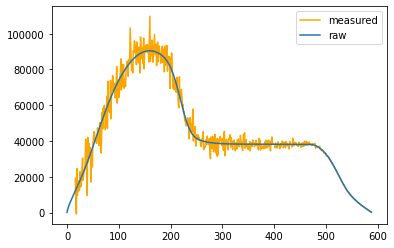

In [22]:

%matplotlib inline
m = dset['/hgv/HGV_0/measured']
plt.plot(m.t, m.alt, c='orange', label='measured')
v = dset['/hgv/HGV_0/raw']
plt.plot(v.t, v.alt, label='raw')
plt.legend()

In [23]:
# Train-val-test split data
data_keys = sorted([key for key in dset.keys() if ('raw' in key)&('hgv' in key)])
# Test data       = 20% of total keys
# Validation data = 10% of total keys
# Train data      = 70% of total keys
train_keys, val_keys, test_keys = train_val_test_split(
    data_keys, (0.7, 0.1, 0.2), shuffle=False)

print(f'Train keys: {len(train_keys):>5} -> {len(train_keys)/len(data_keys) * 100}%')
print(f'Valid keys: {len(val_keys):>5} -> {len(val_keys)/len(data_keys) * 100}%')
print(f'Test keys:  {len(test_keys):>5} -> {len(test_keys)/len(data_keys) * 100}%')

Train keys:   700 -> 70.0%
Valid keys:   100 -> 10.0%
Test keys:    200 -> 20.0%


In [24]:
from sklearn.preprocessing import StandardScaler

# Calculate mean and variance over all training set 
print('Calculating mean and variance over all training data...')
scaler = StandardScaler()
means = []
for train_key in tqdm(train_keys):
    traj = RelativeTrajectory(dset[train_key])
    means.append(traj.data.mean(axis=0))

scaler.fit(np.array(means))

Calculating mean and variance over all training data...


StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
print('Mean:')
pd.DataFrame([scaler.mean_], columns=dset[train_key].columns[:-1])

Mean:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,253.195245,-4.44741,47.438657,0.74148,0.000255,-1.996948,45.0317


In [26]:
print('Variance:')
pd.DataFrame([scaler.var_], columns=dset[train_key].columns[:-1])

Variance:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,2510.70446,14.488958,30.97313,0.010034,0.000007,2.148593e-07,28.243728


In [27]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [28]:
max_len_trajectory, min_len_trajectory, key_max, key_min = max_min_len_coordinate(dset, np.concatenate((train_keys, val_keys, test_keys),axis=0))
max_len_trajectory, min_len_trajectory, key_max, key_min

(920, 495, '/hgv/HGV_736/raw', '/hgv/HGV_455/raw')

In [30]:
BATCH_SIZE = 40#40
BATCH_SIZE_TEST=BATCH_SIZE*1//5
SET_LONG = min_len_trajectory
VEC_DIM = 3
MEM_RNN = SET_LONG*5#10
EPOC_NUM = 10

In [75]:
train_data = create_dataset(
    dset,
    train_keys,
    name='train',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=True,
    verbose=True
)
val_data = create_dataset(
    dset,
    val_keys,
    name='validation',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=False,
    verbose=True
)
test_data = create_dataset(
    dset,
    test_keys,
    name='test',
    gt_size=SET_LONG,
    horizon=0,
    step=SET_LONG,
    variables=VEC_DIM,
    residuals=False,
    train=False,
    verbose=True
)

Loading dataset in train mode...



Total trajectory parts: 700
Each: 495 observed + 0 horizon = 495 points in total
Each point contains 3 variables
Data mean:
[99.857 -9.281 56.323]
Data std:
[70.893 17.277 33.864]
Loading dataset in evaluation mode...



Total trajectory parts: 100
Each: 495 observed + 0 horizon = 495 points in total
Each point contains 3 variables
Data mean:
[100.374  -9.467  56.406]
Data std:
[71.641 17.433 33.41 ]
Loading dataset in evaluation mode...



Total trajectory parts: 200
Each: 495 observed + 0 horizon = 495 points in total
Each point contains 3 variables
Data mean:
[100.832 -10.328  55.626]
Data std:
[71.138 18.262 34.004]


In [32]:
array_err = []

In [ ]:
array_err = [20, 27, 33, 60, 99, 109, 121, 127, 132, 135, 178, 185, 187, 200, 209]
for i in range(3):
    for k in array_err:
        train_data.data['data'] = np.append(train_data.data['data'], [test_data.data['data'][k]], axis = 0)
        train_data.data['data_noise'] = np.append(train_data.data['data_noise'],[test_data.data['data_noise'][k]], axis = 0)
        train_data.data['traj_ids'] = np.append(train_data.data['traj_ids'], [test_data.data['traj_ids'][k]], axis = 0)

In [64]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

val_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"
  
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

## Training  

In [66]:
trajectories_rnn = ModuleRNN(vect_dim=VEC_DIM, rnn_num_units=MEM_RNN)
trajectories_rnn.to(device, torch.float32)


criterion = nn.MSELoss() # nn.CrossEntropyLoss()


In [67]:
opt = torch.optim.Adam(trajectories_rnn.parameters(), lr=1e-3, weight_decay=0.1) # lr=1e-4

In [68]:
train_loss = []
val_loss = []
test_loss = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

Discrepancy = 0.05

In [ ]:
load_checkpoint('trajectories_rnn4ep8mem.pth', trajectories_rnn, opt)

In [61]:
EPOC_NUM = 5

Epoch 2 of 10 took 171.660s
      training loss: 0.10731665
    validation loss: 0.107152514
train accuracy: 3.8 %
validation accuracy: 3.4 %


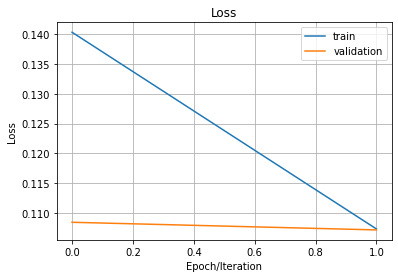

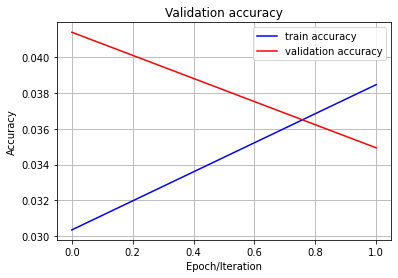

KeyboardInterrupt: ignored

In [69]:
trajectories_rnn, train_loss, val_loss, train_accuracy, val_accuracy, opt = traning_fun(trajectories_rnn, criterion, opt, train_dl, val_dl, train_loss, val_loss, train_accuracy, val_accuracy, Discrepancy, EPOC_NUM, device, draw=True)

In [52]:
save_checkpoint('trajectories_rnn1ep2mem.pth', trajectories_rnn, opt)

model saved to trajectories_rnn4ep8mem.pth


Iteration 25 of 25 took 0.790s
    testing loss: 5.1084695
testing accuracy: 55.8 %


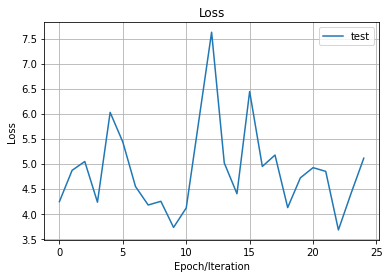

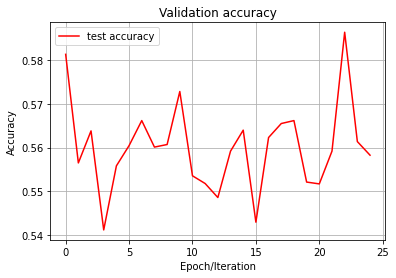

mean test loss: 4.87581
mean test accuracy: 56.0 %


In [39]:
Discrepancy = 0.05
pack_predictions, test_loss, test_accuracy = testing_fun(trajectories_rnn, criterion, test_dl, test_loss, test_accuracy, Discrepancy, device, draw=True)
print('mean test loss:', np.mean(test_loss))
print('mean test accuracy:', np.mean(test_accuracy)*1000//1/10,'%')

In [40]:
def plot_trajectory(data, label=''):
    # display some trajectories for visual representation
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')
    data = np.array(data)
    colors = np.arange(data.shape[0])
    
    # Plot:
    ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap='plasma');
    ax.set_xlabel('X (10^6 m)')
    ax.set_ylabel('Y (10^6 m)')
    ax.set_zlabel('Z (10^6 m)')
    ax.set_title(CLASSNAME.get(label, label))
    
    plt.show()

Kalman

In [41]:

def predict(x, P, F, Q, B, u):
    x = F @ x + B @ u
    P = F @ P @ F.T + Q
    return x, P


def update(x, P, z, R, H, size_coordinates):
    I = np.eye(3*size_coordinates)
    y = z - H @ x
    S = H @ P @ H.T + R
    S_1 = np.linalg.inv(S)
    K = P @ H.T @ S_1
    x = x + K @ y
    P = (I - K @ H) @ P
    return x, P

In [42]:
def FilterKalman(trajectories, size_coordinates, time_step, Q_spector_noise, coordinates_noise, B = None, U = None):
    assert size_coordinates in [1, 2, 3]
    
    dt = time_step

    R = np.eye(size_coordinates) * coordinates_noise**2 #covariance matrix of measurements
    if B == None:
        B = np.zeros(size_coordinates)
    if U == None:
        u = np.zeros(size_coordinates)


    Q = np.array([[dt**5/20, dt**4/8, dt**3/6],
                  [dt**4/8,  dt**3/3, dt**2/2],
                  [dt**3/6,  dt**2/2, dt]])
    Q = Q * Q_spector_noise

    F = np.array([[1., dt, dt**2/2],
                  [0., 1., dt     ],
                  [0., 0., 1.     ]])
    
    H = np.array([1., 0., 0.])
    
    if size_coordinates==3:
        F = block_diag(F, F, F)
        Q = block_diag(Q, Q, Q)
        H = block_diag(H, H, H)
    elif size_coordinates==2:
        F = block_diag(F, F)
        Q = block_diag(Q, Q)
        H = block_diag(H, H)

    x = np.zeros(3*size_coordinates) #the initial prediction
    P = np.eye(3*size_coordinates) * 500. #confidence in the initial prediction

    trajectories_filter = []
    trajectories_filter_x = []
    trajectories_filter_P = []
    
    for id_p, point in enumerate(trajectories):
        x, P = predict(x, P, F, Q, B, u)
        x, P = update(x, P, point, R, H, size_coordinates)
        trajectories_filter.append(x[0::3])
        trajectories_filter_P.append(P[0::3,0::3]@np.ones(size_coordinates))

    return trajectories_filter, trajectories_filter_P


In [43]:
Q_spector_noise  = 100 #the density of the White noise / our trust in the filter
coordinates_noise = 5 #noise sqrt(dispersion) at the radius
size_coordinates = 3
time_step = 0.25

In [44]:
data_trajectories_filter = []
data_trajectories_filter_P = []

for id_b, batch_total in enumerate(test_dl):
    batch_trajectories_filter = []
    batch_data_trajectories_filter_P = []
    for id_t, trajectories in enumerate(batch_total['data_noise'].numpy()):
        traj, traj_P = FilterKalman(trajectories, size_coordinates, time_step, Q_spector_noise, coordinates_noise)
        batch_trajectories_filter.append(traj)
        batch_data_trajectories_filter_P.append(traj_P)
    data_trajectories_filter.append(batch_trajectories_filter)
    data_trajectories_filter_P.append(batch_data_trajectories_filter_P)

# Research

In [45]:
def MSE(data1, data2):
    data = data1 - data2
    data *= data
    return np.sum(data)/data.size

In [70]:
len(test_data.data['data'])

200

In [46]:
def Deviation(data_real, data_rnn, data_kalman, Discrepancy, BATCH_SIZE_TEST, start, array_err):
    loss_rnn = []
    loss_kalman = []
    accuracy_rnn = []
    accuracy_kalman = []
    for k in range(len(data_real)):
        if k in array_err:
            k+=1

        loss_rnn.append(MSE(data_real[k][start:,:], data_rnn[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[start:,:]))
        
        loss_kalman.append(MSE(data_real[k][start:,:], np.array(data_kalman[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[start:,:]))

        accuracy_rnn.append(accuracy(data_rnn[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[start:,:], data_real[k][start:,:], Discrepancy))
        accuracy_kalman.append(accuracy(np.array(data_kalman[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[start:,:], data_real[k][start:,:], Discrepancy))


    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('num trajectory')
    plt.plot(accuracy_kalman, label='kalman accuracy', color ='#1f77b4')
    plt.plot(accuracy_rnn, label='rnn accuracy', color ='#ff7f0e')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('num trajectory')
    plt.plot(loss_rnn, label='rnn loss', color ='#ff7f0e')
    plt.plot(loss_kalman, label='kalman loss', color ='#1f77b4')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return loss_rnn, loss_kalman, accuracy_rnn, accuracy_kalman

In [47]:
start = 3
k = 0

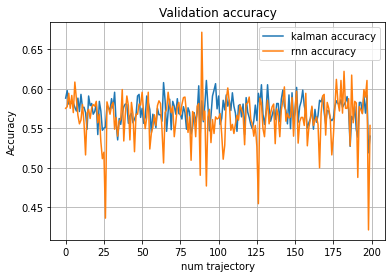

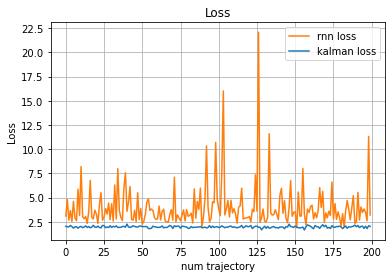

mean loss rnn 3.989915065921041
mean loss kalman 1.9639247296502318
mean accuracy rnn 56.0 %
mean accuracy kalman 57.0 %


In [48]:
loss_rnn, loss_kalman, accuracy_rnn, accuracy_kalman = Deviation(test_data.data['data'], pack_predictions, data_trajectories_filter, Discrepancy, BATCH_SIZE_TEST, start, array_err)
print('mean loss rnn', np.mean(loss_rnn))
print('mean loss kalman', np.mean(loss_kalman))
print('mean accuracy rnn', np.mean(accuracy_rnn)*100//1,'%')
print('mean accuracy kalman', np.mean(accuracy_kalman)*100//1,'%')


In [49]:
k =1

loss_rnn_k = []
loss_kalman_k = []
losss_measurement = []
for i in range(len(test_data.data['data'][k])):
    loss_kalman_k.append([test_data.data['data'][k,i,0] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][0],
                          test_data.data['data'][k,i,1] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][1],
                          test_data.data['data'][k,i,2] -data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][i][2]])
    
    loss_rnn_k.append([test_data.data['data'][k,i,0] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][0],
                       test_data.data['data'][k,i,1] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][1],
                       test_data.data['data'][k,i,2] -pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST].numpy()[i][2]])
    losss_measurement.append([test_data.data['data'][k,i,0]-test_data.data['data_noise'][k,i,0],
                              test_data.data['data'][k,i,1]-test_data.data['data_noise'][k,i,1],
                              test_data.data['data'][k,i,2]-test_data.data['data_noise'][k,i,2]])
loss_kalman_k = np.absolute(np.array(loss_kalman_k))
loss_rnn_k = np.absolute(np.array(loss_rnn_k))
losss_measurement = np.absolute(np.array(losss_measurement))

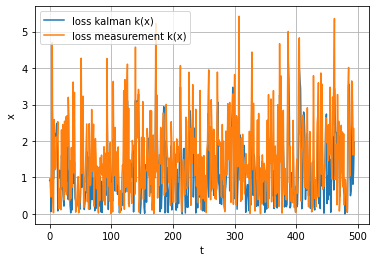

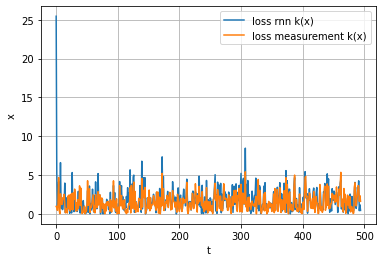

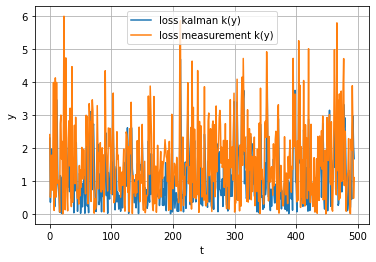

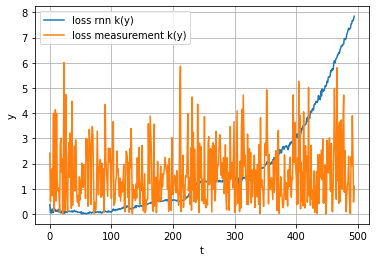

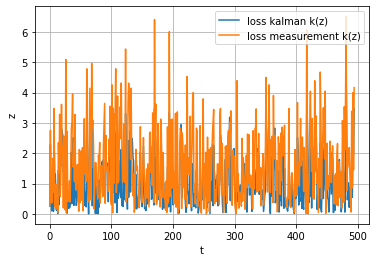

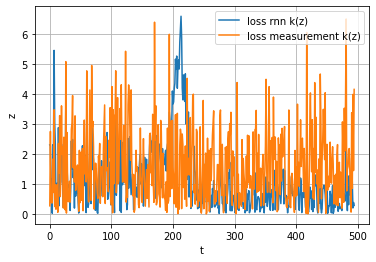

In [50]:
plt.ylabel('x')
plt.xlabel('t')
plt.plot(loss_kalman_k[:,0], label='loss kalman k(x)')
plt.plot(losss_measurement[:,0], label='loss measurement k(x)')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('x')
plt.xlabel('t')
plt.plot(loss_rnn_k[:,0], label='loss rnn k(x)')
plt.plot(losss_measurement[:,0], label='loss measurement k(x)')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('y')
plt.xlabel('t')
plt.plot(loss_kalman_k[:,1], label='loss kalman k(y)')
plt.plot(losss_measurement[:,1], label='loss measurement k(y)')
plt.legend()
plt.grid(True)
plt.show()


plt.ylabel('y')
plt.xlabel('t')
plt.plot(loss_rnn_k[:,1], label='loss rnn k(y)')
plt.plot(losss_measurement[:,1], label='loss measurement k(y)')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('z')
plt.xlabel('t')
plt.plot(loss_kalman_k[:,2], label='loss kalman k(z)')
plt.plot(losss_measurement[:,2], label='loss measurement k(z)')
plt.legend()
plt.grid(True)
plt.show()

plt.ylabel('z')
plt.xlabel('t')
plt.plot(loss_rnn_k[:,2], label='loss rnn k(z)')
plt.plot(losss_measurement[:,2], label='loss measurement k(z)')
plt.legend()
plt.grid(True)
plt.show()

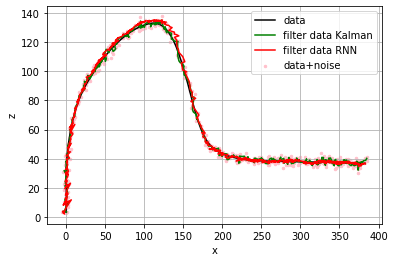

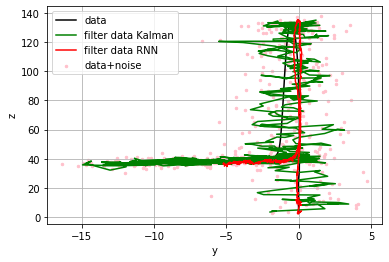

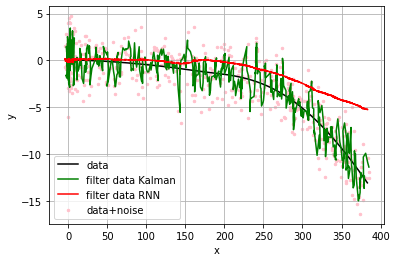

In [51]:
a0 = start
a1 = 0
a2 = 2
plt.ylabel('z')
plt.xlabel('x')
plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.legend()
plt.grid(True)
plt.show()

a1 = 1
a2 = 2
plt.ylabel('z')
plt.xlabel('y')
plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.legend()
plt.grid(True)
plt.show()

a1 = 0
a2 = 1
plt.ylabel('y')
plt.xlabel('x')
plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
plt.legend()
plt.grid(True)
plt.show()

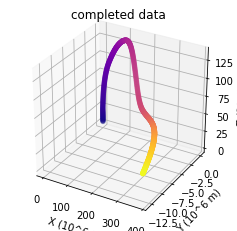

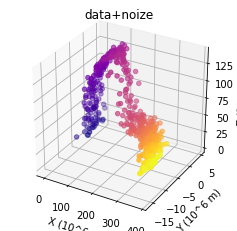

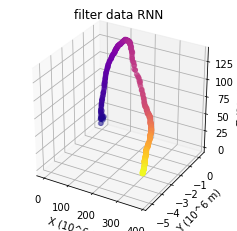

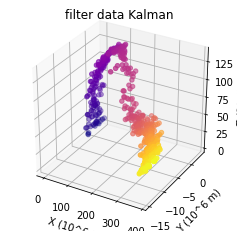

In [52]:
plot_trajectory(test_data.data['data'][k][a0:,:], 'completed data')
plot_trajectory(test_data.data['data_noise'][k][a0:,:], 'data+noize')
plot_trajectory(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,:], 'filter data RNN')
plot_trajectory(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,:], 'filter data Kalman')

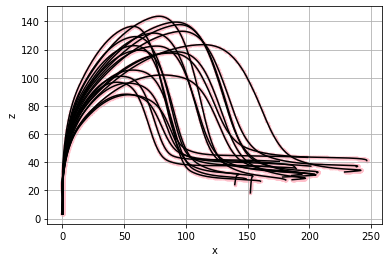

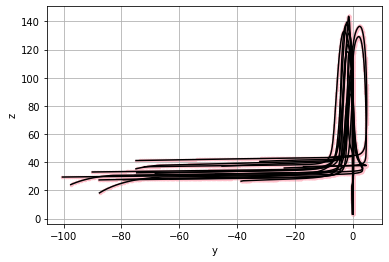

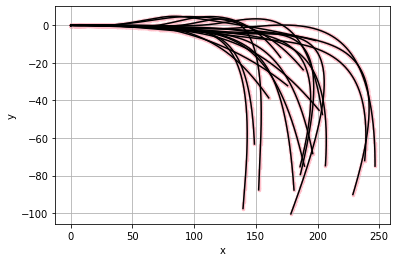

In [76]:
a0 = 3
a1 = 0
a2 = 2
plt.ylabel('z')
plt.xlabel('x')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
#plt.legend()
plt.grid(True)
plt.show()

a1 = 1
a2 = 2
plt.ylabel('z')
plt.xlabel('y')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
#plt.legend()
plt.grid(True)
plt.show()

a1 = 0
a2 = 1
plt.ylabel('y')
plt.xlabel('x')
for k in range(len(test_data.data['data'])//10):
  plt.plot(test_data.data['data'][k][a0:,a1], test_data.data['data'][k][a0:,a2], label='data', color='black')
  plt.scatter(test_data.data['data_noise'][k][a0:,a1], test_data.data['data_noise'][k][a0:,a2], label='data+noise', c='pink', s=6)
#plt.plot(np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a1],np.array(data_trajectories_filter[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST])[a0:,a2], label='filter data Kalman', color='green')
#plt.plot(pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a1], pack_predictions[k//BATCH_SIZE_TEST][k-k//BATCH_SIZE_TEST*BATCH_SIZE_TEST][a0:,a2], label='filter data RNN', color='r')
#plt.legend()
plt.grid(True)
plt.show()